In [2]:
from qiskit_utils import *

## **Task 2 : Missing Number**

Here we will be given a list of numbers where the elements of that list will be numbers that can range from $0$ to $2^n$ for some integer 'n' in any arbitrary manner. However one particular element from the list will be missing and our aim is to find that one !

### **Method : Quantum Approach**

First I will explain how we can solve this problem on a quantum computer and I will approach the problem in the manner suggested in the problem description. My implementation will have the follwoing steps, first we use a QRAM like data loading process to encode the provided data into an phase oracle, next we implement a grover type search which will selectively amplify the required missing number for us ! 

#### **Algorithm**



**Step 1:** Prepare an equal superpoition of all $2^n$ basis states in the `data-register` and $\ket{-}$ state in the `ancilla` register.
$$                  \sum_{x \in \{1,0\}^{n}}\ket{x}  \otimes  \ket{-}
$$
**Step 2:** Apply a oracle operator to the `data-register` such that every basis state $\ket{x}$ other than the missing state $\ket{m}$ acquires a $(-1)$ phase, relatively speaking the $\ket{m}$ will acquire a $(-1)$ phase.
$$                \left(  \sum_{x \in \{1,0\}^{n} / m}\ket{x} - \ket{m} \right) \otimes  \ket{-}
$$
**Step 3:** Apply a diffuser operator that reflects the state about the intial equal superposition state. This step and the previous one essentially completes a grover operation whihc slecctively ampliifes the the missing state $\ket{m}$, thus increasing the probablity of measuring it.

#### **Example**

Here we are tyring the case of $4$ qubits, for demonstration we will randomly pop one element out if it!

In [40]:
num = 4
l = list(range(2**num)) ## prepare list of size 2**num
p = l.pop(np.random.randint(0,2**num - 1)) ## randomly pop out an element
l = np.random.permutation(l) ## randomly permute the input array

In [41]:
def missing_number(input_vector: Union[list, np.array], return_circuit= False): 

    input_list = l
    num_bits = int(np.ceil(np.log2(len(input_list))))
    input_list_bin = [ format(elem, 'b').zfill(num_bits) for elem in input_list ]

    ## initiate circuit ##

    qreg = QuantumRegister(num_bits, name= 'data-register')
    ancilla_2 = QuantumRegister(1, name= 'ancilla')
    qc = QuantumCircuit(qreg, ancilla_2)

    qc.h(qreg)
    qc.x(ancilla_2)
    qc.h(ancilla_2)
    qc.barrier()

    ## append grover operations ##

    num_grover_steps = 1
    for _ in range(num_grover_steps):
        
        ## append oracle ##
        for bin_str in input_list_bin:
            # bin_str = bin_str[::-1]
            for index, bit in enumerate(bin_str):
                if bit == '0': qc.x(qreg[index])
            qc.mcx(qreg, ancilla_2)    
            for index, bit in enumerate(bin_str):
                if bit == '0': qc.x(qreg[index])
            qc.barrier()

        ## append diffuser ##
        qc.barrier()
        qc.h(qreg)
        qc.x(qreg)
        qc.mcx(qreg, ancilla_2)
        qc.x(qreg)
        qc.h(qreg)    

    qc.barrier()


    ## measure circuit ##
    counts = measure_and_plot(qc, shots=100,measure_cntrls= False, return_counts= True, decimal_count_keys= True)

    ## find string with max counts ##
    items = list(counts.items())
    c0 = items[0]
    for c1 in items[1:] :
        if c1[1] > c0[1]: c0 = c1

    if return_circuit:
        return (c0[0], counts, qc) 
    else:
        return c0[0]


In [42]:
missing_elem, probaibility_over_missing_elems, qc = missing_number(l, return_circuit= True)
missing_elem, p

(2, 2)

The element returned from the `missing_number` function is same as the popped out element `p` !

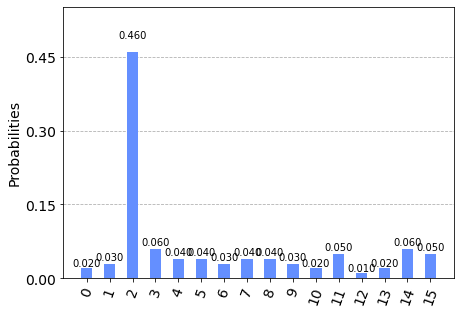

In [43]:
measure_and_plot(qc, shots=100,measure_cntrls= False, cntrl_specifier= 2, decimal_count_keys= True)

In [ ]:
qc.draw()

#### **Discussion**
One can easily verify that the above example is generalisable to any number of qubits. As for the grover search is concerned, since there is just one element being searched out of $2^n$ possible elements usually a single grover operation suffices in significantly amplifying the missing state $\ket{m}$. But incase more than one basis state are missing no. of required grover operation may vary.

However, even though the above algorithm works it is not a very effecient quantum algorithm in terms of circuit depth, CNOT counts etc. For example, to implement the phase oracle we required $2^n - 1$ operations where each of them involves multi-controlled 'toffoli' with $n$ controls i,e in overall $\mathcal{O}(p(n)\:2^n)$ basic operations. Where $p(n)$ is the number of basic operations a n-controlled toffoli breaks up into. 

 Note that we can getaway by designing an phase-oracle that adds a negative phase to the $\ket{m}$ state only and this could be achieved by a constant depth circuit, but that would involve knowing the $\ket{m}$ beforehand, thus obliviating the aim of our algorihtm.

In [34]:
qc.depth()

98

To check if we are really having any quantum advantage we should ask if we can solve this problem any faster using classical algorithms ? To discuss more on this, next I will give some overview how a classical approach might perform better for this specific problem.

### **Method :  Classical Approach**

Since our aim is to find a missing number out of a otherwise consecutive set of numbers we may consider sorting the array of numbers as it is and then checking for the missing element by scanning through the sorted array! 

Now any **comparison-based** sorting algorithm takes $\mathcal{O}(N\:log(N))$ iterations at max to sort a random array of size $N$, thus in our case $\left(N = 2^n\right)$ it will take around $\mathcal{O}(2^n\:n)$ steps which is same as the quantum case mentioned above. Though **integer-sorting** algorithms are usually faster than the former we won't have significant advantage as the elements to be stored are mostly consecutive. 

However if there is just one element we can take a different approach that can find the missing element in just $\mathcal{O}(n)$ steps. I will explain the procedure with an example.

Say the given list of elements is `list = [ 0, 2, 1, 4, 5, 6, 7]`,

**Step 1:** Convert all elements into binary strings of suitable length ;
            `list = [(000), (010), (001), (100), (101), (110), (111)]`, and use the index $b_0$, $b_1$ . . $b_d$ to denote the bits with $b_0$ being the Most Significant Bit `(MSB)` and $b_d$ the Least Significant Bit `(LSB)`. 
            
**Step 2:** Starting with $b_0$, count the number of `1`s and `0`s over all the elements in the `list`. For $b_0$, there are 4 `1`s and 3 `0`s indicating that the missing element must have `0` in the $b_0$.

**Step 3:** Next we repeat the **Step 2** for $b_1$ but only on the elements that have `0` in the $b_0$ ;
`list = [(000), (010), (001)]`. In this step we have 2 `0`s and 1 `1`, indicating the missing elements has `1` in the $b_1$.

**Step 4:** Finally we compare $b_2$, but only with elements that have $b_0 = $`0` and $b_1 = $`1` i.e `list = [(010)]`. Thus identifying the missing element as `(011)` i.e `3`. 


The procedure outlined above is genralisable for any number of elements. The time complexity can be calculated by noting that at each step we reduce the size of the elements in the list by half, thus comparison runs over $2^n$, $2^{n-1}$  . . so on for every iteration . Since 
$ 1 + 2 + 4 + . . . 2^n = 2^{n+1} - 1
$,
The algorithm takes $\mathcal{O}(2^{n+1})$ steps thus outperforming the the quantum algorithm! 